In [ ]:
# default_exp training

# Training Data

In [1]:
#export
from random import randint
import random
from pathlib import Path
from PIL import Image, ImageDraw
import pandas as pd
from collections import namedtuple
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import PIL
import chessocr
import re
from itertools import product
from IPython.core.pylabtools import print_figure

In [2]:
#export
boards_url = Path(chessocr.__file__).parent.parent/"img/boards"
pieces_url = Path(chessocr.__file__).parent.parent/"img/pieces"
m = re.compile('^[0-9]+$')
piece_dirs = sorted([_ for _ in pieces_url.iterdir() if m.match(_.name)], key=lambda i: int(i.name))

## Boards and Board

In [3]:
#export
def assert_coord(coord):
    assert len(coord)==2
    assert coord[0] in 'abcdefgh'
    assert coord[1] in '12345678'

In [4]:
#export
class Board:
    """ 
        Represents a rendered board with particular dark and light colors.
        There are no pieces on the board.
        
        so far assumes the board is oriented towards the white player
    """
    _filemap=dict(zip('abcdefgh', '12345678'))
    _rankmap=dict(zip('12345678', '87654321'))
    def __init__(self, url): 
        self.url = url
        self.reset()
    def _repr_png_(self): return self.img._repr_png_()
    def reset(self): self.img = Image.open(self.url).convert('RGBA')
    def bbox(self, coord):
        """ bounding box for chess coordinate like a8, b7, f6, etc """
        assert_coord(coord)
        file=int(self._filemap[coord[0]])-1
        rank=int(self._rankmap[coord[1]])-1
        dx=self.img.size[0]//8
        dy=self.img.size[1]//8
        x0=file*dx
        y0=rank*dy
        x1=x0+dx
        y1=y0+dy
        return (x0, y0, x1, y1,)

In [5]:
Board(get_image_files(boards_url)[10]).bbox('a1')

(0, 350, 50, 400)

In [6]:
Board(get_image_files(boards_url)[11]).bbox('a1')

(0, 350, 50, 400)

In [7]:
get_image_files(boards_url)[11]

Path('/Users/id/nbs/07-chessocrnb/img/boards/21.png')

In [8]:
#export
class Boards:
    """ 
        Container object holding `Board` objects.
    """
    def __init__(self, url):
        self.url = url
        self.boards = [Board(_) for _ in get_image_files(self.url)]
        self._png_data = None
    def __len__(self): return len(self.boards)
    def __getitem__(self, key): return self.boards[key]
    def __iter__(self): return self.boards.__iter__()
    def _repr_png_(self): 
        if not self._png_data:
            self._png_data = self._figure_data('png')
        return self._png_data

    def _figure_data(self, format):
        rows = len(self) // 9 + 1
        fig, axs = plt.subplots(rows, 7, figsize=(14, 8))
        for i in range(len(self)):
            ax=axs.ravel()[i]
            ax.imshow(self[i].img)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"{i}")

        data = print_figure(fig)
        plt.close(fig)
        return data

In [9]:
boards = Boards(boards_url)

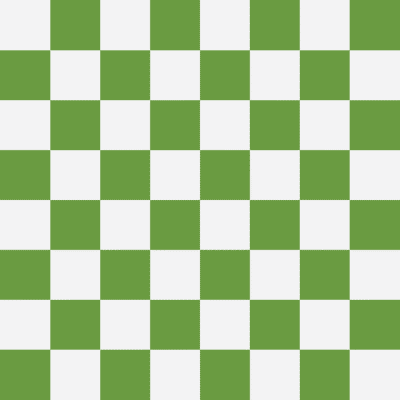

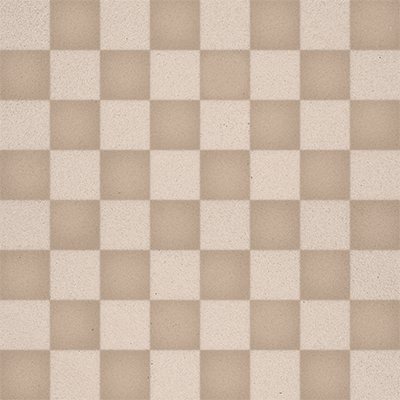

In [10]:
boards[27]; boards[14]

## PieceSet and PieceSets

In [11]:
#export
class Piece:
    """ non data descriptor """
    def __set_name__(self, owner, name): self.name=name
    def __get__(self, obj, type=None): return Image.open(obj.dir/f'{self.name[1]}_{self.name[0]}.png').convert('RGBA')

In [12]:
class PieceSet:
    """ 
        Represents the 12 individual pieces comprising a chess set. 
        This includes a rook, knight, bishop, queen, king, and pawn for both black and white pieces.
    """
    _attrs = [f'{_[0]}{_[1]}' for _ in product('wb', 'rnbqkp')]
    wr=Piece()
    wn=Piece()
    wb=Piece()
    wq=Piece()
    wk=Piece()
    wp=Piece()
    
    br=Piece()
    bn=Piece()
    bb=Piece()
    bq=Piece()
    bk=Piece()
    bp=Piece()
    
    def __init__(self, dir): 
        self.dir = dir
        self._png_data = None
        
    def _repr_png_(self):
        if not self._png_data:
            self._png_data = self._figure_data('png')
        return self._png_data

    def _figure_data(self, format):
        fig, axs = plt.subplots(2, 6, gridspec_kw={'hspace':-0.5, 'wspace':0}, figsize=(8, 4))
        for i, attr in enumerate(list(self._attrs)):
            ax=axs.ravel()[i]
            ax.imshow(getattr(self, attr))
            ax.set_xticks([])
            ax.set_yticks([])
    
        fig.suptitle(self.dir.as_posix())
        data = print_figure(fig)
        plt.close(fig)
        return data

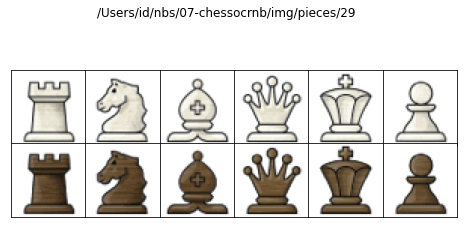

In [13]:
idx = random.randint(0, len(piece_dirs)-1)
PieceSet(piece_dirs[idx])

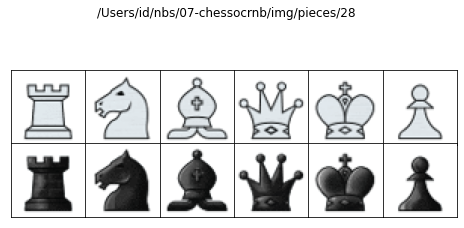

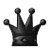

In [14]:
idx = random.randint(0, len(piece_dirs)-1)
PieceSet(piece_dirs[idx])
PieceSet(piece_dirs[idx]).bq

In [15]:
#export
class PieceSets:
    def __init__(self, dirs): self.sets = [PieceSet(_) for _ in dirs]
    def __getitem__(self, key): return self.sets[key]
    def __len__(self): return len(self.sets)

In [16]:
#export
pieces=PieceSets(piece_dirs)

## FEN

In [72]:
#export
def converter(p):
    if p.isupper():
        return f'w{p.lower()}'
    else:
        return f'b{p.lower()}'

In [77]:
#export
class FEN(Board):
    """ represents a fen string with convenience methods to find the piece on each square """
    
    _filemap=dict(zip('abcdefgh', range(0, 9)))
    _rankmap=dict(zip('12345678', range(0, 64, 8)[::-1]))    
    
    def __init__(self, fen):
        chars='RNBQKPrnbqkp/12345678'
        assert fen.count("/") == 7
        assert all([_ in chars for _ in fen])
        self.fen=fen
        assert len(self.fenfull)==64
    
    def __repr__(self): 
        return "\n".join([self.fenfull[0:8],
                          self.fenfull[8:16],
                          self.fenfull[16:24],
                          self.fenfull[24:32],
                          self.fenfull[32:40],
                          self.fenfull[40:48],
                          self.fenfull[48:56],
                          self.fenfull[56:],
                         ]) 
    
    @property
    def fenfull(self):
        """ fen rep with no numbers just to make things easier"""
        f = self.fen
        for i in '12345678': f=f.replace(i, '_'*int(i))
        return f.replace("/", "")

    def __iter__(self):
        return iter([(f'{f}{r}', converter(getattr(self, f'{f}{r}')),) 
                     for f, r, in product('abcdefgh', '12345678') 
                     if getattr(self, f'{f}{r}') != '_'])
    
    def __getattr__(self, attr):
        assert_coord(attr)
        file=self._filemap[attr[0]]
        rank=self._rankmap[attr[1]]
        idx = file+rank
        return self.fenfull[idx]

In [142]:
s="rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR"
FEN(s)

rnbqkbnr
pppppppp
________
________
____P___
________
PPPP_PPP
RNBQKBNR

In [144]:
start="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
FEN(start)

rnbqkbnr
pppppppp
________
________
________
________
PPPPPPPP
RNBQKBNR

In [81]:
test_eq(FEN(s).e4, 'P')
test_eq(FEN(s).a1, 'R')
test_eq(FEN(s).a8, 'r')
test_eq(FEN(s).h1, 'R')
test_eq(FEN(s).h8, 'r')
test_eq(FEN(s).e3, '_')
test_eq(FEN(s).e1, 'K')
test_eq(FEN(s).e8, 'k')
test_eq(FEN(s).c5, '_')

## GameBoard

In [145]:
#export
class GameBoard:
    """
        Represents a combination of a Board, PieceSet, and optionally a FEN to create the position.
        If no fen is provided, the GameBoard will be in the starting position
    """
    def __init__(self, board, pieces, fen=FEN("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR")):
        self.board = board
        self.pieces = pieces
        self.fen=fen
        self._render()
        
    def _render(self):
        if not self.fen:
            return
        for s, p in self.fen:
            img=self.board.img
            board=self.board
            pieces=self.pieces
            img.paste(getattr(pieces, p), board.bbox(s), getattr(pieces, p))
        
    def _repr_png_(self):
        return self.board._repr_png_()

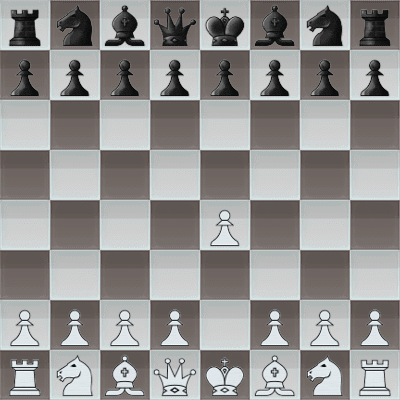

In [197]:
idx1 = random.randint(0, len(boards)-1)
idx2 = random.randint(0, len(pieces)-1)
boards[idx1].reset()
gb = GameBoard(boards[idx1], pieces[idx], FEN(s)); gb

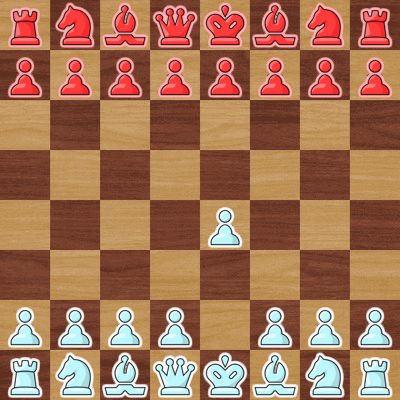

In [157]:
gb = GameBoard(boards[0], pieces[22], FEN(s)); gb